In [3]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt

import GPy

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

#from numpy_functions import sin_2d, radial

import warnings
warnings.filterwarnings('ignore')
from scipy.interpolate import CubicSpline as spline
from scipy.io import loadmat
from scipy.interpolate import Akima1DInterpolator as akima
from scipy.integrate import quad
from scipy.optimize import root, minimize_scalar
from sklearn.utils import resample
from scipy.stats import uniform#, trapezoid
import tikzplotlib as tpl

In [4]:
np.random.seed(42)

# Global parameters
n_samples = 1000
input_dim = 2

# Uniformly distributed inputs
lb = -1 * np.ones(input_dim)
ub = 1 * np.ones(input_dim)

def inputs_uniform(n_samples, n_pars, lb,  ub):
    return np.vstack(np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(n_pars)]).T)

def profile(active, ss, f_out, N=1):
    return np.array([f_out(ss.inverse_transform(active)[0]) for i in range(N)])

# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub)
nor = Normalizer(lb, ub)

def cons(x, normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    return (x[:,0]+2*x[:,1])**2+1*(x[:, 0]-2*x[:, 1])-3

# Define the output of interest and compute the gradients
#func = partial(cons, normalizer=None)#, r=generatrix)
# dfdx = lambda x : (10*(x[:, 0]-x[:, 1]))
# dfdy = lambda x : (-10*(x[:, 0]-x[:, 1]))
# df = np.vstack((dfdx(X).flatten(),dfdy(X).flatten())).T
df = egrad(cons)(X)

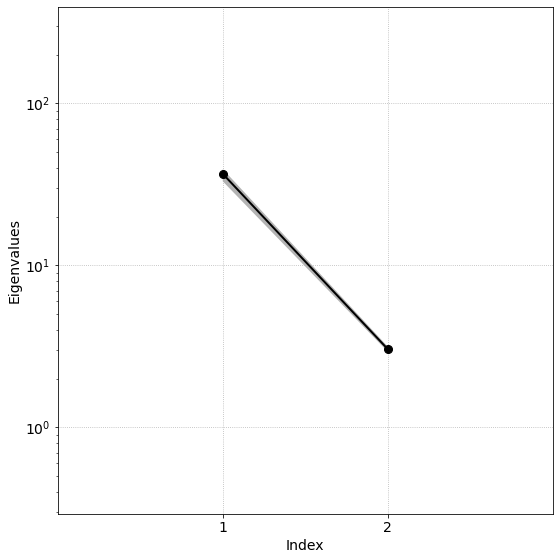

[36.77353779  3.03811201]


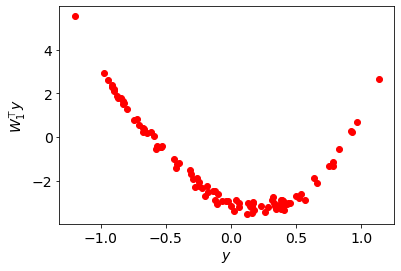

In [5]:
# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)

asub.plot_eigenvalues()
#print(asub.evects)
print(asub.evals)

M_test = 100
X_test = inputs_uniform(M_test, input_dim, lb, ub)
nor = Normalizer(lb, ub)
x_test = nor.fit_transform(X_test)
x_forward = asub.transform(x_test)[0]
sample_f = profile(x_forward, asub, cons, 25)
g = np.mean(sample_f,axis=0)

plt.figure(figsize=(6, 4))
plt.scatter(x_forward, g, c='r', label='Optimal profile')
plt.xlabel("$y$")
plt.ylabel("$W_1^\\top y$")

tpl.save("optprofile.tex")
plt.show()

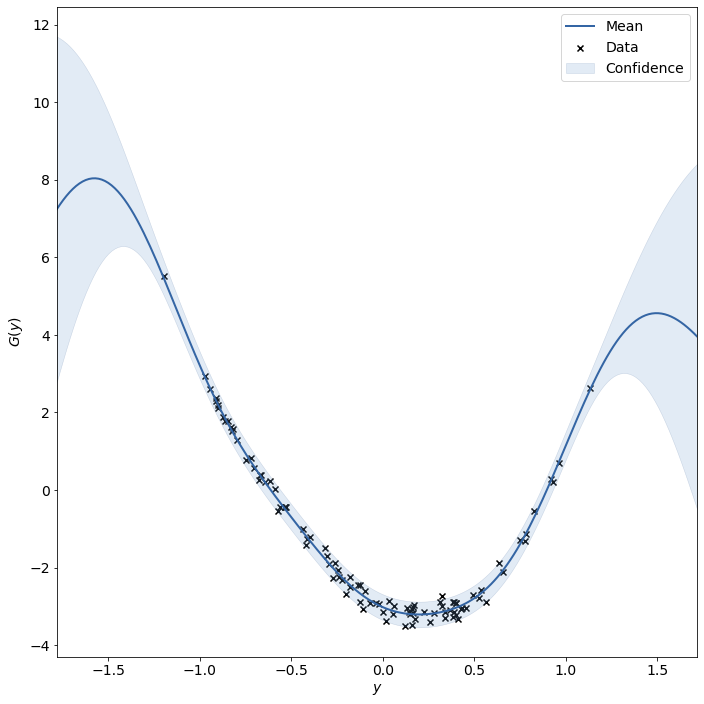

Relative Root Mean Square Error for optimal profile: 1.577%


In [4]:
sig = 0.1
gp_g = GPy.models.GPRegression(x_forward, g.reshape(-1, 1), noise_var=sig)

gp_g.constrain_positive('')
gp_g.optimize_restarts(5, verbose=False)

y_g = gp_g.predict(x_forward)[0]

gp_g.plot(figsize=(10,10))
plt.xlabel("$y$")
plt.ylabel("$G(y)$")
tpl.save("gpfit.tex")
plt.show()

def RRMSE(test, true):
    return np.sqrt(np.sum((test.reshape(-1) - true.reshape(-1))**2) )#/ np.sum((true - true.mean())**2))

print("Relative Root Mean Square Error for optimal profile: {:.3f}%".format(RRMSE(y_g, g)))

[[0.38417958 0.92325839]]
[[-0.92325839  0.38417958]]


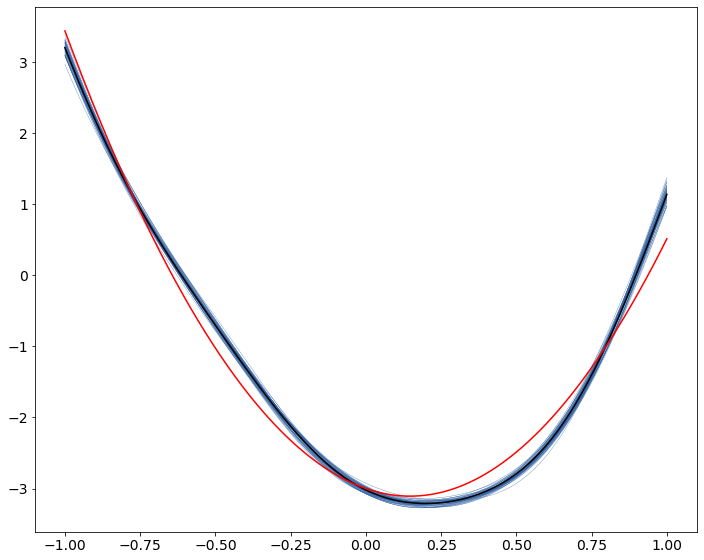

In [5]:
t = np.linspace(-1,1,100).reshape((100,1))
Ymean_b = gp_g.predict(t) 
gp_g.plot_samples(samples=50, plot_limits=[-1,1], figsize=(10,8))
plt.plot(t,Ymean_b[0].flatten(),c="k")

## This plots the exact value of g on the active subspace
subeig = asub.evects[:,0].reshape((1,2))
print(subeig)
print(asub.evects[:,1].reshape((1,2)))

exactg = []
#prof = []
nsamp = 400
xx = np.linspace(-1,1,nsamp)
for i in range(nsamp):
    exactg.append(cons(xx[i] * subeig))
    #prof.append(profile(np.array([[xx[i]]]), asub, cons))
plt.plot(xx,exactg,c="r")
#plt.plot(xx,prof,c="k")
plt.show()

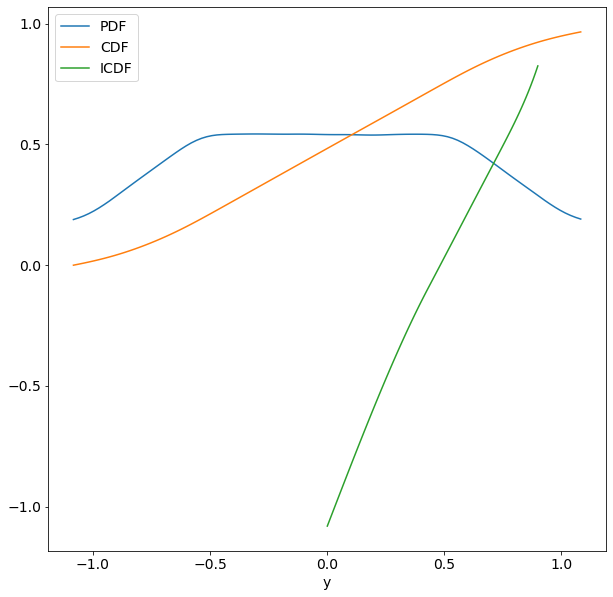

In [6]:
data = loadmat("data_fit_prob.mat")
ii = np.linspace(-0.1,0.9,100)
xx = data["T"]
yy = data["smoothcurve"]
pdf = akima(xx.flatten(),yy.flatten())
cdf = lambda x : list(map(lambda y : quad(pdf,np.min(xx),y)[0], x))
icdf = akima(np.hstack((0,cdf(ii),1)),np.hstack((np.min(xx),ii,np.max(xx))))
plt.figure(figsize=(10,10))
plt.plot(xx.flatten(),pdf(xx.flatten()),label='PDF')
plt.plot(xx.flatten(),cdf(xx.flatten()),label='CDF')
plt.plot(ii,icdf(ii),label='ICDF')
plt.xlabel("y")
plt.legend()
tpl.save("density.tex")
plt.show()

class Ydist:
    def cdf(self, x):
        return cdf(x)
    def pdf(self, x):
        return pdf(x)

def sample_py(N):
    sample = np.random.uniform(0, 1, N)
    val = np.zeros(N)
    for i in range(N):
        val[i] = root(lambda x : cdf(x)[0] - sample[i], 0.5)["x"]
    return val

#params = trapezoid.fit(sample_py(250))

In [7]:
actvec = np.array([0.38417958,0.92325839])
angle = np.arctan(0.92325839/0.38417958)#*180/np.pi
a = 0
bc = [2,2/np.tan(angle)]
b = np.min(bc)
c = np.max(bc)
d = 2 + 2/np.tan(angle)

In [8]:
# Initial parameters
betal = 0
betau = 10
beta_eps = (betau+betal)/2
tol = 1e-2
err = np.inf
tau = 0.95
n = 0
mode = True # Mode == true uses bootstraping, Mode == false uses Chernoff bounds

while err > tol and n<=25:

    # Fit biased GPR
    sig = 0.1
    gp_g_b = GPy.models.GPRegression(x_forward, g.reshape(-1, 1)+beta_eps, noise_var=sig)

    gp_g_b.constrain_positive('')
    gp_g_b.optimize_restarts(5, verbose=False)
    print(f"Iteration {n} : fit done")

    # Generate S sample from training data
    fhat = gp_g_b.predict(x_forward.reshape((M_test,1)),include_likelihood=True)[0].reshape((M_test,1))
    randix = np.random.randint(0,25,size=M_test)
    Sk = fhat.flatten() - sample_f[randix,:].diagonal().flatten()
    avgSk = np.mean(Sk)

    nboot = 5000
    avg = np.zeros(nboot)
    var = np.zeros(nboot)
    if mode: # bootstraping only
        for i in range(nboot):
            avg[i] = np.mean(resample(np.array(Sk.flatten()),n_samples=M_test)>0)
        prob = np.mean(avg)
    else: # chernoff inequality
        # Compute bootstrap estimator for expected value
        for i in range(nboot):
            avg[i] = np.mean(resample(np.array(Sk.flatten()),n_samples=M_test))
            var[i] = np.var(resample(np.array(Sk.flatten()),n_samples=M_test), ddof=1)
        avgSkboot = np.mean(avg)
        varSkboot = np.mean(var)
        # print(avgSkboot)
        # print(varSkboot)
        print(f"Iteration {n} : bootstrap estimator done (Eboot[S] = {avgSkboot}, Vboot[S] = {varSkboot})")

        if(avgSkboot < 0):
            betal = beta_eps
            beta_eps = (betau+betal)/2
            print(f"Iteration {n} : expected value = {avgSkboot} < 0. Increasing bias.")
        else:
            # Approximate Chernoff bound
            def Chernoff():
                f = lambda x : np.mean(np.exp(x * (np.abs(Sk - avgSkboot) - avgSkboot)))
                #print((np.abs(Sk - avgSkboot) - avgSkboot))
                # ax = np.linspace(0,100,100)
                # plt.plot(ax,list(map(f,ax)))
                # plt.show()
                result = minimize_scalar(f,bounds=(0,100),method="bounded")
                #print(result)
                return result["fun"]
            
            Ci = np.zeros(1)
            for i in range(1):
                Ci[i] = Chernoff()
            prob = np.mean(1-Ci)
            print(f"Iteration {n} : concentration bound done")

    err = np.abs(prob-tau)

    beta_previous = beta_eps
    if prob > tau:
        betau = beta_eps
    else:
        betal = beta_eps
    beta_eps = (betau+betal)/2

    print(f"Iteration {n} : bias = {beta_previous}, success probability = {prob}")
        
    n = n + 1


if (n>25):
    print(f"Iteration {n} : diverged")
    if beta_previous/np.mean(sample_f[randix,:].diagonal().flatten()) < 1e-3 :
        print(f"Bias is small relative to function average. Target probability might be lower than the no-bias conservativeness.")

Iteration 0 : fit done
Iteration 0 : bias = 5.0, success probability = 1.0
Iteration 1 : fit done
Iteration 1 : bias = 2.5, success probability = 1.0
Iteration 2 : fit done
Iteration 2 : bias = 1.25, success probability = 0.870358
Iteration 3 : fit done
Iteration 3 : bias = 1.875, success probability = 0.9898119999999999
Iteration 4 : fit done
Iteration 4 : bias = 1.5625, success probability = 0.940214


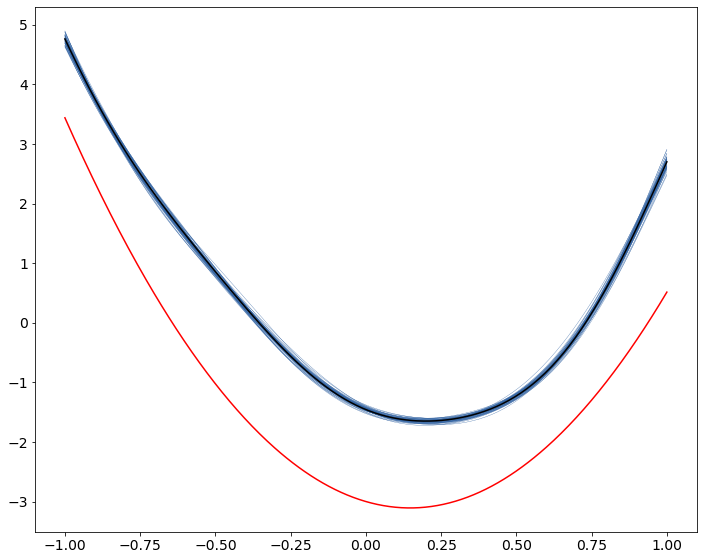

In [9]:

t = np.linspace(-1,1,100).reshape((100,1))
Ymean_b = gp_g_b.predict(t) 
gp_g_b.plot_samples(samples=50, plot_limits=[-1,1], figsize=(10,8))
plt.plot(t,Ymean_b[0].flatten(),c="k")

## This plots the exact value of g on the active subspace
subeig = asub.evects[:,0].reshape((1,2))
exactg = []
nsamp = 400
xx = np.linspace(-1,1,nsamp)
for i in range(nsamp):
    exactg.append(cons(xx[i] * subeig))
plt.plot(xx,exactg,c="r")

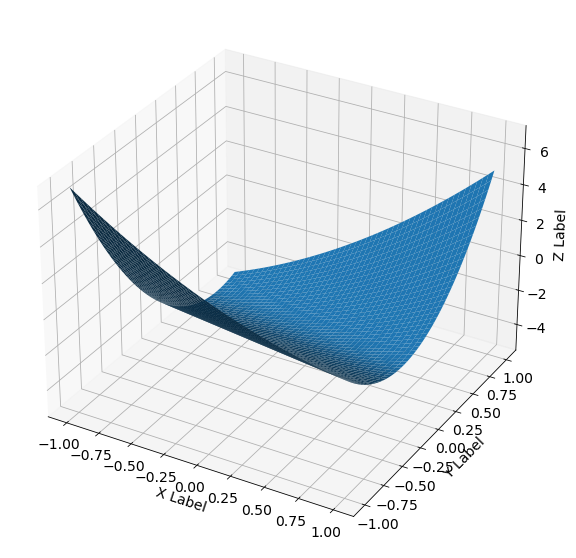

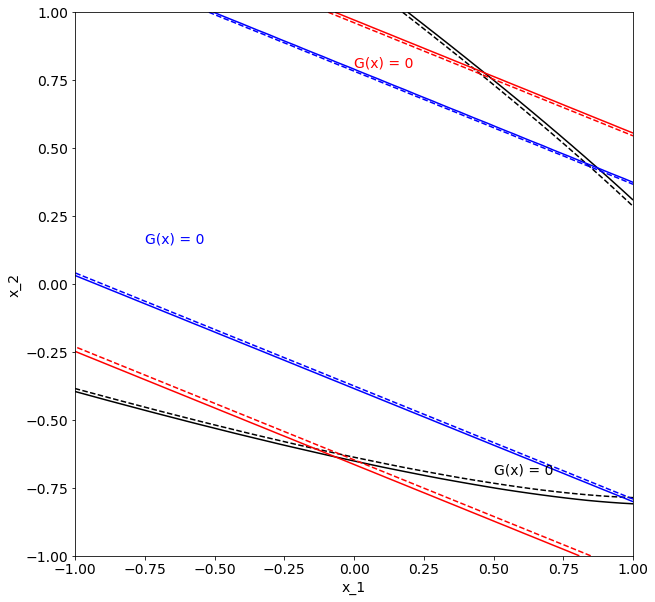

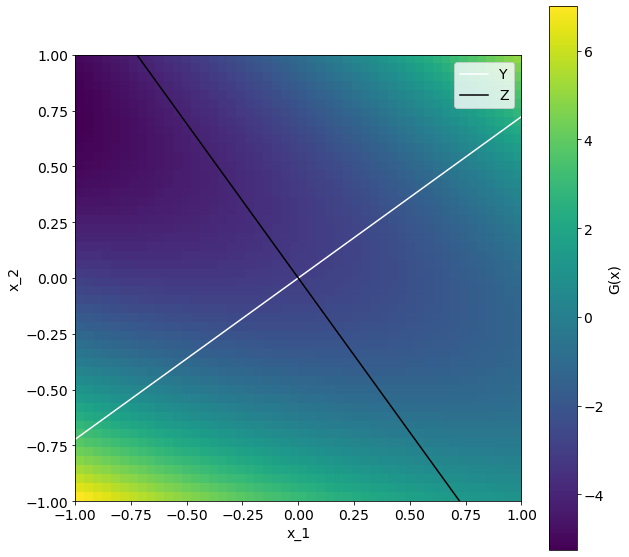

In [10]:
meshX, meshY = np.meshgrid(np.linspace(-1,1,50),np.linspace(-1,1,50))
argin = np.vstack((meshX.flatten(),meshY.flatten())).T
fargin = cons(argin).reshape((50,50), order="C")
vargin = gp_g_b.predict(asub.transform(argin)[0])[0].reshape((50,50), order="C")
gargin = gp_g.predict(asub.transform(argin)[0])[0].reshape((50,50), order="C")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(meshX, meshY, fargin)

# K = 200
# yk = sample_py(K)
# fhat = gp_g_b.predict(yk.reshape((K,1)),include_likelihood=True)[0].reshape((K,1))
# gp_g_b.predict(yk.reshape((K,1)),include_likelihood=True)[0].reshape((K,1))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.figure(figsize=(10,10))
#plt.imshow(fargin,extent=[-1,1,-1,1],origin="lower")
plt.contour(meshX,meshY,fargin,[-0.1,0],colors="k",linestyle="dashed")
plt.contour(meshX,meshY,vargin,[-0.05,0],colors="b",linestyle="solid")
plt.contour(meshX,meshY,gargin,[-0.1,0],colors="r",linestyle="solid")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.annotate('G(x) = 0',(0.5,-0.7))
plt.annotate('G(x) = 0',(0,0.8),color="r")
plt.annotate('G(x) = 0',(-0.75,0.15),color="b")
tpl.save("cons.tex")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(fargin,extent=[-1,1,-1,1],origin="lower")
plt.colorbar(label="G(x)")
plt.plot([-1,1],[-0.723,0.723],color="w",label="Y")
plt.plot([-0.723,0.723],[1,-1],color="k",label="Z")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
tpl.save("active.tex")
plt.show()

In [11]:
# Observed Conservativeness
M = 10000
uu = uniform.rvs(loc=0,scale=1,size=M)
yk = icdf(uu)
fhat = gp_g_b.predict(yk.reshape((M,1)))[0].reshape((M,1)) # approx constraint
fyz = cons(asub.inverse_transform(yk.reshape((M,1)))[0]) # exact constraint
np.sum(fhat.flatten() > fyz.flatten())/M



0.949

In [12]:
# Unfeasibility Ratio
M = 10000
uu = uniform.rvs(loc=0,scale=1,size=M)
yk = icdf(uu)
fhat = gp_g_b.predict(yk.reshape((M,1)))[0].reshape((M,1)) # approx constraint
fyz = cons(asub.inverse_transform(yk.reshape((M,1)))[0]) # exact constraint
np.sum(np.logical_and(fhat.flatten() < 0, fyz.flatten() > 0))/np.sum(fhat.flatten() < 0)

0.0014186912573151268